In [1]:
#---This program is used to forecast 1 week CDRs based on 55 previous days' data

#---Install these bibs so the program works properly
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from numpy import loadtxt
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
#--Loading Cell_ID vector, whose elements tell from which ID the matrix_TS row is the corresponding time-series

Cell_ID = loadtxt('ID_labels.csv', delimiter=',') 
df = pd.read_csv('matrixTS.csv',header=None)
df.head(6)

,0,1,2,3,4,5,6,7,8,9,...,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487
0,13,11,8,7,8,9,11,12,13,18,...,23.0,17.0,20.0,16.0,16.0,18.0,19.0,21.0,17.0,13.0
1,13,11,10,7,6,9,11,11,13,17,...,22.0,15.0,20.0,15.0,15.0,18.0,20.0,19.0,17.0,13.0
2,15,11,9,11,9,8,12,18,23,31,...,6.0,9.0,9.0,11.0,8.0,7.0,7.0,8.0,7.0,5.0
3,12,11,7,9,6,6,8,15,12,23,...,14.0,12.0,17.0,17.0,15.0,14.0,12.0,13.0,14.0,10.0
4,10,8,11,7,8,8,12,16,16,16,...,28.0,26.0,23.0,26.0,27.0,19.0,18.0,20.0,14.0,18.0
5,11,8,7,6,8,8,6,7,12,14,...,14.0,13.0,12.0,14.0,14.0,12.0,12.0,16.0,11.0,10.0


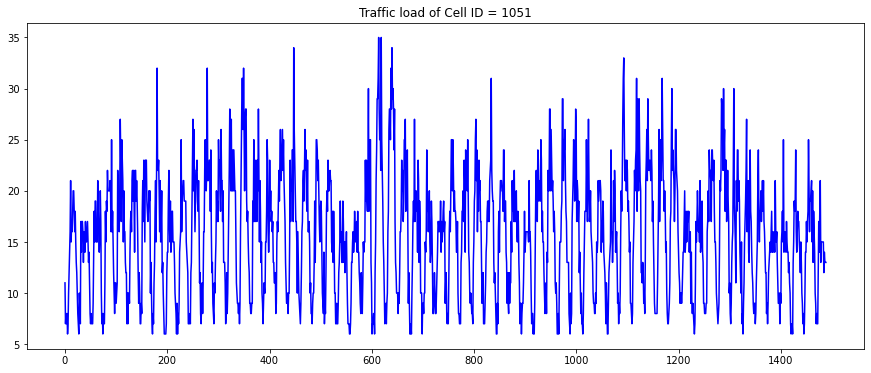

In [3]:
#--Defines the Cell ID to be forecasted and plots the corresponding time-series

days = 62 #Train and validation size need to be changed if this value is tunned
matrix = df.to_numpy()

ID=60
time_series = matrix[ID][:]
hour = np.linspace(0,24*days,24*days)

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell ID = %d' % (Cell_ID[60])) 
plt.plot(hour,time_series,'b')

In [4]:
#---This function creates the sliding window to construct the training data set

def df_to_X_y(df,window_size):
    df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]] 
        X.append(row)
        y.append(df_as_np[i+window_size])
    return np.array(X), np.array(y)

#-Each vector of matrix X contains "window_size" elements used as input to train the model
#-Each element of vector y contains one element that the model needs to predict based on the respective row of X

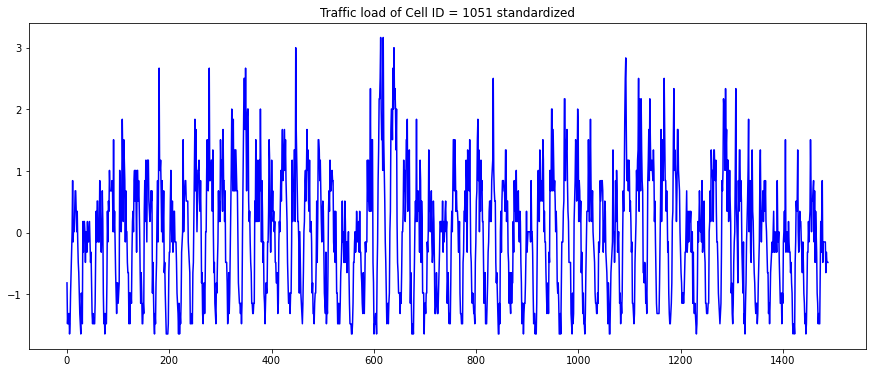

In [5]:
#---Standardization of the CDR time-series

train_size = 24*50 # defines number of samples of training data: 50 days with 24 samples each
validation_size = 24*5 # defines number of samples of validation data: 5 days with 24 samples each

time_series_mean = time_series[:train_size].mean() #--Considering just the training part
time_series_std = time_series[:train_size].std() #--Considering just the training part

time_series_standardized = (time_series - time_series_mean) / time_series_std

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell ID = %d standardized' % (Cell_ID[60])) 
plt.plot(hour,time_series_standardized,'b')

In [6]:
WINDOW_SIZE = 24
X,y = df_to_X_y(time_series_standardized,WINDOW_SIZE)
X.shape, y.shape

((1464, 24, 1), (1464,))

## Splitting data to training and testing

In [7]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:(train_size+validation_size)], y[train_size:(train_size+validation_size)]
y_test = time_series[(train_size+validation_size):]

X_train.shape, X_val.shape

((1200, 24, 1), (120, 24, 1))

## Constructing LSTM model

In [8]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE,1)))

#-Comment or uncomment lines to insert/remove layers of the LSTM
#-Change the number of neurons inside each layers

#model1.add(LSTM(128,return_sequences=True)) # default activation function is tanh
#model1.add(LSTM(128,return_sequences=True)) # default activation function is tanh
model1.add(LSTM(64,return_sequences=True)) # default activation function is tanh
model1.add(LSTM(64)) # default activation function is tanh

model1.add(Dense(32,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


In [9]:
#--Model Training

#-Set the hyperparemeters according to your application: learning_rate, epochs, batch size
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train,y_train, validation_data=(X_val,y_val),epochs=1000, batch_size=32)

Train on 1200 samples, validate on 120 samples
Epoch 1/1000
1200/1200 [==============================] - 3s 3ms/sample - loss: 0.9527 - root_mean_squared_error: 0.9760 - val_loss: 0.9054 - val_root_mean_squared_error: 0.9515
Epoch 2/1000
1200/1200 [==============================] - 1s 526us/sample - loss: 0.8332 - root_mean_squared_error: 0.9128 - val_loss: 0.8110 - val_root_mean_squared_error: 0.9005
Epoch 3/1000
1200/1200 [==============================] - 1s 524us/sample - loss: 0.6700 - root_mean_squared_error: 0.8185 - val_loss: 0.6839 - val_root_mean_squared_error: 0.8270
Epoch 4/1000
1200/1200 [==============================] - 1s 523us/sample - loss: 0.4874 - root_mean_squared_error: 0.6982 - val_loss: 0.5071 - val_root_mean_squared_error: 0.7121
Epoch 5/1000
1200/1200 [==============================] - 1s 525us/sample - loss: 0.3471 - root_mean_squared_error: 0.5892 - val_loss: 0.3784 - val_root_mean_squared_error: 0.6151
Epoch 6/1000
1200/1200 [==============================]

1200/1200 [==============================] - 1s 530us/sample - loss: 0.2241 - root_mean_squared_error: 0.4733 - val_loss: 0.3007 - val_root_mean_squared_error: 0.5483
Epoch 47/1000
1200/1200 [==============================] - 1s 525us/sample - loss: 0.2246 - root_mean_squared_error: 0.4739 - val_loss: 0.3022 - val_root_mean_squared_error: 0.5497
Epoch 48/1000
1200/1200 [==============================] - 1s 529us/sample - loss: 0.2238 - root_mean_squared_error: 0.4731 - val_loss: 0.3107 - val_root_mean_squared_error: 0.5574
Epoch 49/1000
1200/1200 [==============================] - 1s 539us/sample - loss: 0.2228 - root_mean_squared_error: 0.4720 - val_loss: 0.3132 - val_root_mean_squared_error: 0.5596
Epoch 50/1000
1200/1200 [==============================] - 1s 534us/sample - loss: 0.2226 - root_mean_squared_error: 0.4718 - val_loss: 0.3154 - val_root_mean_squared_error: 0.5616
Epoch 51/1000
1200/1200 [==============================] - 1s 527us/sample - loss: 0.2248 - root_mean_squared

1200/1200 [==============================] - 1s 527us/sample - loss: 0.2120 - root_mean_squared_error: 0.4604 - val_loss: 0.3110 - val_root_mean_squared_error: 0.5577
Epoch 92/1000
1200/1200 [==============================] - 1s 546us/sample - loss: 0.2138 - root_mean_squared_error: 0.4624 - val_loss: 0.3037 - val_root_mean_squared_error: 0.5511
Epoch 93/1000
1200/1200 [==============================] - 1s 534us/sample - loss: 0.2120 - root_mean_squared_error: 0.4604 - val_loss: 0.3030 - val_root_mean_squared_error: 0.5504
Epoch 94/1000
1200/1200 [==============================] - 1s 536us/sample - loss: 0.2120 - root_mean_squared_error: 0.4605 - val_loss: 0.3049 - val_root_mean_squared_error: 0.5522
Epoch 95/1000
1200/1200 [==============================] - 1s 537us/sample - loss: 0.2128 - root_mean_squared_error: 0.4613 - val_loss: 0.3000 - val_root_mean_squared_error: 0.5477
Epoch 96/1000
1200/1200 [==============================] - 1s 533us/sample - loss: 0.2111 - root_mean_squared

1200/1200 [==============================] - 1s 541us/sample - loss: 0.2103 - root_mean_squared_error: 0.4586 - val_loss: 0.3009 - val_root_mean_squared_error: 0.5485
Epoch 137/1000
1200/1200 [==============================] - 1s 529us/sample - loss: 0.2089 - root_mean_squared_error: 0.4571 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 138/1000
1200/1200 [==============================] - 1s 534us/sample - loss: 0.2080 - root_mean_squared_error: 0.4561 - val_loss: 0.2988 - val_root_mean_squared_error: 0.5467
Epoch 139/1000
1200/1200 [==============================] - 1s 540us/sample - loss: 0.2116 - root_mean_squared_error: 0.4600 - val_loss: 0.2915 - val_root_mean_squared_error: 0.5399
Epoch 140/1000
1200/1200 [==============================] - 1s 538us/sample - loss: 0.2090 - root_mean_squared_error: 0.4572 - val_loss: 0.2982 - val_root_mean_squared_error: 0.5461
Epoch 141/1000
1200/1200 [==============================] - 1s 530us/sample - loss: 0.2090 - root_mean_sq

1200/1200 [==============================] - 1s 536us/sample - loss: 0.2059 - root_mean_squared_error: 0.4537 - val_loss: 0.3017 - val_root_mean_squared_error: 0.5492
Epoch 182/1000
1200/1200 [==============================] - 1s 536us/sample - loss: 0.2078 - root_mean_squared_error: 0.4558 - val_loss: 0.2976 - val_root_mean_squared_error: 0.5455
Epoch 183/1000
1200/1200 [==============================] - 1s 546us/sample - loss: 0.2048 - root_mean_squared_error: 0.4526 - val_loss: 0.3012 - val_root_mean_squared_error: 0.5489
Epoch 184/1000
1200/1200 [==============================] - 1s 536us/sample - loss: 0.2054 - root_mean_squared_error: 0.4532 - val_loss: 0.2953 - val_root_mean_squared_error: 0.5434
Epoch 185/1000
1200/1200 [==============================] - 1s 538us/sample - loss: 0.2046 - root_mean_squared_error: 0.4523 - val_loss: 0.3048 - val_root_mean_squared_error: 0.5520
Epoch 186/1000
1200/1200 [==============================] - 1s 544us/sample - loss: 0.2075 - root_mean_sq

1200/1200 [==============================] - 1s 547us/sample - loss: 0.2037 - root_mean_squared_error: 0.4514 - val_loss: 0.2977 - val_root_mean_squared_error: 0.5456
Epoch 227/1000
1200/1200 [==============================] - 1s 547us/sample - loss: 0.2049 - root_mean_squared_error: 0.4527 - val_loss: 0.2965 - val_root_mean_squared_error: 0.5445
Epoch 228/1000
1200/1200 [==============================] - 1s 551us/sample - loss: 0.2047 - root_mean_squared_error: 0.4524 - val_loss: 0.3001 - val_root_mean_squared_error: 0.5479
Epoch 229/1000
1200/1200 [==============================] - 1s 540us/sample - loss: 0.2042 - root_mean_squared_error: 0.4518 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 230/1000
1200/1200 [==============================] - 1s 545us/sample - loss: 0.2026 - root_mean_squared_error: 0.4501 - val_loss: 0.3007 - val_root_mean_squared_error: 0.5484
Epoch 231/1000
1200/1200 [==============================] - 1s 552us/sample - loss: 0.2024 - root_mean_sq

1200/1200 [==============================] - 1s 539us/sample - loss: 0.1996 - root_mean_squared_error: 0.4468 - val_loss: 0.2947 - val_root_mean_squared_error: 0.5428
Epoch 272/1000
1200/1200 [==============================] - 1s 546us/sample - loss: 0.2016 - root_mean_squared_error: 0.4490 - val_loss: 0.2945 - val_root_mean_squared_error: 0.5427
Epoch 273/1000
1200/1200 [==============================] - 1s 546us/sample - loss: 0.2007 - root_mean_squared_error: 0.4480 - val_loss: 0.2935 - val_root_mean_squared_error: 0.5417
Epoch 274/1000
1200/1200 [==============================] - 1s 545us/sample - loss: 0.2027 - root_mean_squared_error: 0.4503 - val_loss: 0.2985 - val_root_mean_squared_error: 0.5464
Epoch 275/1000
1200/1200 [==============================] - 1s 544us/sample - loss: 0.2003 - root_mean_squared_error: 0.4476 - val_loss: 0.2984 - val_root_mean_squared_error: 0.5463
Epoch 276/1000
1200/1200 [==============================] - 1s 547us/sample - loss: 0.2009 - root_mean_sq

1200/1200 [==============================] - 1s 559us/sample - loss: 0.1975 - root_mean_squared_error: 0.4444 - val_loss: 0.3017 - val_root_mean_squared_error: 0.5493
Epoch 317/1000
1200/1200 [==============================] - 1s 549us/sample - loss: 0.1953 - root_mean_squared_error: 0.4419 - val_loss: 0.2951 - val_root_mean_squared_error: 0.5432
Epoch 318/1000
1200/1200 [==============================] - 1s 546us/sample - loss: 0.1994 - root_mean_squared_error: 0.4466 - val_loss: 0.3027 - val_root_mean_squared_error: 0.5502
Epoch 319/1000
1200/1200 [==============================] - 1s 554us/sample - loss: 0.2010 - root_mean_squared_error: 0.4483 - val_loss: 0.3016 - val_root_mean_squared_error: 0.5492
Epoch 320/1000
1200/1200 [==============================] - 1s 538us/sample - loss: 0.1961 - root_mean_squared_error: 0.4428 - val_loss: 0.2853 - val_root_mean_squared_error: 0.5342
Epoch 321/1000
1200/1200 [==============================] - 1s 546us/sample - loss: 0.1958 - root_mean_sq

1200/1200 [==============================] - 1s 532us/sample - loss: 0.1937 - root_mean_squared_error: 0.4402 - val_loss: 0.2965 - val_root_mean_squared_error: 0.5445
Epoch 362/1000
1200/1200 [==============================] - 1s 544us/sample - loss: 0.1964 - root_mean_squared_error: 0.4432 - val_loss: 0.2924 - val_root_mean_squared_error: 0.5408
Epoch 363/1000
1200/1200 [==============================] - 1s 538us/sample - loss: 0.1943 - root_mean_squared_error: 0.4408 - val_loss: 0.3022 - val_root_mean_squared_error: 0.5497
Epoch 364/1000
1200/1200 [==============================] - 1s 586us/sample - loss: 0.1923 - root_mean_squared_error: 0.4386 - val_loss: 0.3039 - val_root_mean_squared_error: 0.5513
Epoch 365/1000
1200/1200 [==============================] - 1s 538us/sample - loss: 0.1958 - root_mean_squared_error: 0.4425 - val_loss: 0.3010 - val_root_mean_squared_error: 0.5487
Epoch 366/1000
1200/1200 [==============================] - 1s 530us/sample - loss: 0.1927 - root_mean_sq

1200/1200 [==============================] - 1s 536us/sample - loss: 0.1904 - root_mean_squared_error: 0.4364 - val_loss: 0.3024 - val_root_mean_squared_error: 0.5499
Epoch 407/1000
1200/1200 [==============================] - 1s 540us/sample - loss: 0.1903 - root_mean_squared_error: 0.4362 - val_loss: 0.3030 - val_root_mean_squared_error: 0.5504
Epoch 408/1000
1200/1200 [==============================] - 1s 548us/sample - loss: 0.1908 - root_mean_squared_error: 0.4368 - val_loss: 0.3051 - val_root_mean_squared_error: 0.5523
Epoch 409/1000
1200/1200 [==============================] - 1s 544us/sample - loss: 0.1912 - root_mean_squared_error: 0.4372 - val_loss: 0.3119 - val_root_mean_squared_error: 0.5585
Epoch 410/1000
1200/1200 [==============================] - 1s 535us/sample - loss: 0.1894 - root_mean_squared_error: 0.4352 - val_loss: 0.3098 - val_root_mean_squared_error: 0.5566
Epoch 411/1000
1200/1200 [==============================] - 1s 565us/sample - loss: 0.1909 - root_mean_sq

1200/1200 [==============================] - 1s 546us/sample - loss: 0.1849 - root_mean_squared_error: 0.4299 - val_loss: 0.3257 - val_root_mean_squared_error: 0.5707
Epoch 452/1000
1200/1200 [==============================] - 1s 553us/sample - loss: 0.1875 - root_mean_squared_error: 0.4330 - val_loss: 0.3165 - val_root_mean_squared_error: 0.5626
Epoch 453/1000
1200/1200 [==============================] - 1s 535us/sample - loss: 0.1858 - root_mean_squared_error: 0.4310 - val_loss: 0.3136 - val_root_mean_squared_error: 0.5600
Epoch 454/1000
1200/1200 [==============================] - 1s 540us/sample - loss: 0.1839 - root_mean_squared_error: 0.4288 - val_loss: 0.3390 - val_root_mean_squared_error: 0.5823
Epoch 455/1000
1200/1200 [==============================] - 1s 543us/sample - loss: 0.1887 - root_mean_squared_error: 0.4344 - val_loss: 0.3309 - val_root_mean_squared_error: 0.5753
Epoch 456/1000
1200/1200 [==============================] - 1s 549us/sample - loss: 0.1860 - root_mean_sq

1200/1200 [==============================] - 1s 531us/sample - loss: 0.1830 - root_mean_squared_error: 0.4278 - val_loss: 0.3226 - val_root_mean_squared_error: 0.5680
Epoch 497/1000
1200/1200 [==============================] - 1s 534us/sample - loss: 0.1835 - root_mean_squared_error: 0.4284 - val_loss: 0.3154 - val_root_mean_squared_error: 0.5616
Epoch 498/1000
1200/1200 [==============================] - 1s 536us/sample - loss: 0.1822 - root_mean_squared_error: 0.4269 - val_loss: 0.3245 - val_root_mean_squared_error: 0.5696
Epoch 499/1000
1200/1200 [==============================] - 1s 539us/sample - loss: 0.1805 - root_mean_squared_error: 0.4248 - val_loss: 0.3372 - val_root_mean_squared_error: 0.5807
Epoch 500/1000
1200/1200 [==============================] - 1s 541us/sample - loss: 0.1804 - root_mean_squared_error: 0.4247 - val_loss: 0.3263 - val_root_mean_squared_error: 0.5712
Epoch 501/1000
1200/1200 [==============================] - 1s 532us/sample - loss: 0.1814 - root_mean_sq

1200/1200 [==============================] - 1s 537us/sample - loss: 0.1760 - root_mean_squared_error: 0.4196 - val_loss: 0.3365 - val_root_mean_squared_error: 0.5801
Epoch 542/1000
1200/1200 [==============================] - 1s 535us/sample - loss: 0.1782 - root_mean_squared_error: 0.4221 - val_loss: 0.3507 - val_root_mean_squared_error: 0.5922
Epoch 543/1000
1200/1200 [==============================] - 1s 534us/sample - loss: 0.1769 - root_mean_squared_error: 0.4206 - val_loss: 0.3338 - val_root_mean_squared_error: 0.5778
Epoch 544/1000
1200/1200 [==============================] - 1s 532us/sample - loss: 0.1774 - root_mean_squared_error: 0.4212 - val_loss: 0.3244 - val_root_mean_squared_error: 0.5695
Epoch 545/1000
1200/1200 [==============================] - 1s 538us/sample - loss: 0.1765 - root_mean_squared_error: 0.4201 - val_loss: 0.3310 - val_root_mean_squared_error: 0.5753
Epoch 546/1000
1200/1200 [==============================] - 1s 534us/sample - loss: 0.1781 - root_mean_sq

1200/1200 [==============================] - 1s 554us/sample - loss: 0.1721 - root_mean_squared_error: 0.4148 - val_loss: 0.3377 - val_root_mean_squared_error: 0.5811
Epoch 587/1000
1200/1200 [==============================] - 1s 545us/sample - loss: 0.1703 - root_mean_squared_error: 0.4127 - val_loss: 0.3741 - val_root_mean_squared_error: 0.6116
Epoch 588/1000
1200/1200 [==============================] - 1s 545us/sample - loss: 0.1732 - root_mean_squared_error: 0.4162 - val_loss: 0.3357 - val_root_mean_squared_error: 0.5794
Epoch 589/1000
1200/1200 [==============================] - 1s 543us/sample - loss: 0.1707 - root_mean_squared_error: 0.4132 - val_loss: 0.3490 - val_root_mean_squared_error: 0.5907
Epoch 590/1000
1200/1200 [==============================] - 1s 566us/sample - loss: 0.1735 - root_mean_squared_error: 0.4166 - val_loss: 0.3456 - val_root_mean_squared_error: 0.5879
Epoch 591/1000
1200/1200 [==============================] - 1s 533us/sample - loss: 0.1719 - root_mean_sq

1200/1200 [==============================] - 1s 543us/sample - loss: 0.1678 - root_mean_squared_error: 0.4096 - val_loss: 0.3756 - val_root_mean_squared_error: 0.6129
Epoch 632/1000
1200/1200 [==============================] - 1s 546us/sample - loss: 0.1666 - root_mean_squared_error: 0.4082 - val_loss: 0.3580 - val_root_mean_squared_error: 0.5983
Epoch 633/1000
1200/1200 [==============================] - 1s 547us/sample - loss: 0.1669 - root_mean_squared_error: 0.4086 - val_loss: 0.3475 - val_root_mean_squared_error: 0.5895
Epoch 634/1000
1200/1200 [==============================] - 1s 543us/sample - loss: 0.1678 - root_mean_squared_error: 0.4097 - val_loss: 0.4072 - val_root_mean_squared_error: 0.6381
Epoch 635/1000
1200/1200 [==============================] - 1s 556us/sample - loss: 0.1671 - root_mean_squared_error: 0.4088 - val_loss: 0.3624 - val_root_mean_squared_error: 0.6020
Epoch 636/1000
1200/1200 [==============================] - 1s 559us/sample - loss: 0.1673 - root_mean_sq

1200/1200 [==============================] - 1s 549us/sample - loss: 0.1614 - root_mean_squared_error: 0.4018 - val_loss: 0.3531 - val_root_mean_squared_error: 0.5942
Epoch 677/1000
1200/1200 [==============================] - 1s 539us/sample - loss: 0.1620 - root_mean_squared_error: 0.4025 - val_loss: 0.3754 - val_root_mean_squared_error: 0.6127
Epoch 678/1000
1200/1200 [==============================] - 1s 578us/sample - loss: 0.1615 - root_mean_squared_error: 0.4018 - val_loss: 0.3699 - val_root_mean_squared_error: 0.6082
Epoch 679/1000
1200/1200 [==============================] - 1s 540us/sample - loss: 0.1632 - root_mean_squared_error: 0.4039 - val_loss: 0.3614 - val_root_mean_squared_error: 0.6011
Epoch 680/1000
1200/1200 [==============================] - 1s 574us/sample - loss: 0.1624 - root_mean_squared_error: 0.4030 - val_loss: 0.3946 - val_root_mean_squared_error: 0.6282
Epoch 681/1000
1200/1200 [==============================] - 1s 554us/sample - loss: 0.1622 - root_mean_sq

1200/1200 [==============================] - 1s 576us/sample - loss: 0.1534 - root_mean_squared_error: 0.3916 - val_loss: 0.3975 - val_root_mean_squared_error: 0.6305
Epoch 722/1000
1200/1200 [==============================] - 1s 542us/sample - loss: 0.1560 - root_mean_squared_error: 0.3950 - val_loss: 0.3945 - val_root_mean_squared_error: 0.6281
Epoch 723/1000
1200/1200 [==============================] - 1s 543us/sample - loss: 0.1554 - root_mean_squared_error: 0.3942 - val_loss: 0.3776 - val_root_mean_squared_error: 0.6145
Epoch 724/1000
1200/1200 [==============================] - 1s 554us/sample - loss: 0.1559 - root_mean_squared_error: 0.3949 - val_loss: 0.3848 - val_root_mean_squared_error: 0.6203
Epoch 725/1000
1200/1200 [==============================] - 1s 539us/sample - loss: 0.1549 - root_mean_squared_error: 0.3935 - val_loss: 0.3891 - val_root_mean_squared_error: 0.6238
Epoch 726/1000
1200/1200 [==============================] - 1s 535us/sample - loss: 0.1567 - root_mean_sq

1200/1200 [==============================] - 1s 540us/sample - loss: 0.1487 - root_mean_squared_error: 0.3856 - val_loss: 0.4137 - val_root_mean_squared_error: 0.6432
Epoch 767/1000
1200/1200 [==============================] - 1s 534us/sample - loss: 0.1493 - root_mean_squared_error: 0.3864 - val_loss: 0.3931 - val_root_mean_squared_error: 0.6270
Epoch 768/1000
1200/1200 [==============================] - 1s 539us/sample - loss: 0.1472 - root_mean_squared_error: 0.3836 - val_loss: 0.3811 - val_root_mean_squared_error: 0.6173
Epoch 769/1000
1200/1200 [==============================] - 1s 541us/sample - loss: 0.1472 - root_mean_squared_error: 0.3836 - val_loss: 0.4108 - val_root_mean_squared_error: 0.6409
Epoch 770/1000
1200/1200 [==============================] - 1s 566us/sample - loss: 0.1483 - root_mean_squared_error: 0.3851 - val_loss: 0.4175 - val_root_mean_squared_error: 0.6462
Epoch 771/1000
1200/1200 [==============================] - 1s 544us/sample - loss: 0.1506 - root_mean_sq

1200/1200 [==============================] - 1s 546us/sample - loss: 0.1452 - root_mean_squared_error: 0.3810 - val_loss: 0.4214 - val_root_mean_squared_error: 0.6492
Epoch 812/1000
1200/1200 [==============================] - 1s 536us/sample - loss: 0.1411 - root_mean_squared_error: 0.3756 - val_loss: 0.4057 - val_root_mean_squared_error: 0.6369
Epoch 813/1000
1200/1200 [==============================] - 1s 532us/sample - loss: 0.1397 - root_mean_squared_error: 0.3738 - val_loss: 0.3975 - val_root_mean_squared_error: 0.6304
Epoch 814/1000
1200/1200 [==============================] - 1s 548us/sample - loss: 0.1383 - root_mean_squared_error: 0.3719 - val_loss: 0.4141 - val_root_mean_squared_error: 0.6435
Epoch 815/1000
1200/1200 [==============================] - 1s 535us/sample - loss: 0.1400 - root_mean_squared_error: 0.3741 - val_loss: 0.4001 - val_root_mean_squared_error: 0.6325
Epoch 816/1000
1200/1200 [==============================] - 1s 533us/sample - loss: 0.1406 - root_mean_sq

1200/1200 [==============================] - 1s 547us/sample - loss: 0.1323 - root_mean_squared_error: 0.3637 - val_loss: 0.4091 - val_root_mean_squared_error: 0.6396
Epoch 857/1000
1200/1200 [==============================] - 1s 539us/sample - loss: 0.1308 - root_mean_squared_error: 0.3617 - val_loss: 0.4534 - val_root_mean_squared_error: 0.6734
Epoch 858/1000
1200/1200 [==============================] - 1s 533us/sample - loss: 0.1363 - root_mean_squared_error: 0.3691 - val_loss: 0.3947 - val_root_mean_squared_error: 0.6283
Epoch 859/1000
1200/1200 [==============================] - 1s 549us/sample - loss: 0.1338 - root_mean_squared_error: 0.3658 - val_loss: 0.4152 - val_root_mean_squared_error: 0.6444
Epoch 860/1000
1200/1200 [==============================] - 1s 546us/sample - loss: 0.1336 - root_mean_squared_error: 0.3654 - val_loss: 0.4130 - val_root_mean_squared_error: 0.6427
Epoch 861/1000
1200/1200 [==============================] - 1s 547us/sample - loss: 0.1317 - root_mean_sq

1200/1200 [==============================] - 1s 558us/sample - loss: 0.1243 - root_mean_squared_error: 0.3525 - val_loss: 0.4180 - val_root_mean_squared_error: 0.6465
Epoch 902/1000
1200/1200 [==============================] - 1s 559us/sample - loss: 0.1264 - root_mean_squared_error: 0.3555 - val_loss: 0.4081 - val_root_mean_squared_error: 0.6388
Epoch 903/1000
1200/1200 [==============================] - 1s 584us/sample - loss: 0.1249 - root_mean_squared_error: 0.3534 - val_loss: 0.4052 - val_root_mean_squared_error: 0.6365
Epoch 904/1000
1200/1200 [==============================] - 1s 569us/sample - loss: 0.1271 - root_mean_squared_error: 0.3565 - val_loss: 0.4201 - val_root_mean_squared_error: 0.6482
Epoch 905/1000
1200/1200 [==============================] - 1s 539us/sample - loss: 0.1268 - root_mean_squared_error: 0.3561 - val_loss: 0.4137 - val_root_mean_squared_error: 0.6432
Epoch 906/1000
1200/1200 [==============================] - 1s 569us/sample - loss: 0.1240 - root_mean_sq

1200/1200 [==============================] - 1s 534us/sample - loss: 0.1182 - root_mean_squared_error: 0.3439 - val_loss: 0.4353 - val_root_mean_squared_error: 0.6597
Epoch 947/1000
1200/1200 [==============================] - 1s 545us/sample - loss: 0.1158 - root_mean_squared_error: 0.3403 - val_loss: 0.4552 - val_root_mean_squared_error: 0.6747
Epoch 948/1000
1200/1200 [==============================] - 1s 535us/sample - loss: 0.1177 - root_mean_squared_error: 0.3431 - val_loss: 0.4591 - val_root_mean_squared_error: 0.6776
Epoch 949/1000
1200/1200 [==============================] - 1s 550us/sample - loss: 0.1159 - root_mean_squared_error: 0.3405 - val_loss: 0.4375 - val_root_mean_squared_error: 0.6614
Epoch 950/1000
1200/1200 [==============================] - 1s 549us/sample - loss: 0.1173 - root_mean_squared_error: 0.3425 - val_loss: 0.4317 - val_root_mean_squared_error: 0.6570
Epoch 951/1000
1200/1200 [==============================] - 1s 544us/sample - loss: 0.1162 - root_mean_sq

1200/1200 [==============================] - 1s 600us/sample - loss: 0.1110 - root_mean_squared_error: 0.3332 - val_loss: 0.4108 - val_root_mean_squared_error: 0.6409
Epoch 992/1000
1200/1200 [==============================] - 1s 588us/sample - loss: 0.1161 - root_mean_squared_error: 0.3408 - val_loss: 0.4654 - val_root_mean_squared_error: 0.6822
Epoch 993/1000
1200/1200 [==============================] - 1s 561us/sample - loss: 0.1102 - root_mean_squared_error: 0.3319 - val_loss: 0.4294 - val_root_mean_squared_error: 0.6553
Epoch 994/1000
1200/1200 [==============================] - 1s 552us/sample - loss: 0.1079 - root_mean_squared_error: 0.3285 - val_loss: 0.4556 - val_root_mean_squared_error: 0.6750
Epoch 995/1000
1200/1200 [==============================] - 1s 577us/sample - loss: 0.1091 - root_mean_squared_error: 0.3304 - val_loss: 0.4197 - val_root_mean_squared_error: 0.6478
Epoch 996/1000
1200/1200 [==============================] - 1s 563us/sample - loss: 0.1101 - root_mean_sq

In [10]:
#---Predictions for "N_day_pred" days

predictions_standardized = []
vec_last_samples = X_val[len(y_val)-1]

vec_last_samples = vec_last_samples.reshape((vec_last_samples.shape[1], vec_last_samples.shape[0], 1))

N_day_pred = 7
for i in range(0,24*N_day_pred):
    prediction = model1.predict(vec_last_samples).flatten() #flatten() is just to take the []
    predictions_standardized.append(prediction)
    
    for j in range(0,WINDOW_SIZE-1):
        vec_last_samples[0,j,0] = vec_last_samples[0,j+1,0]
    vec_last_samples[0,int(WINDOW_SIZE-1),0] = prediction
    #print(vec_last_samples)

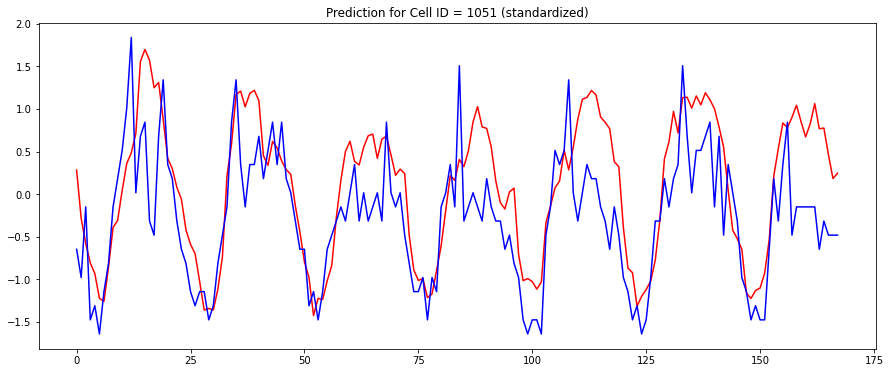

In [11]:
#---Plotting the predictions

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d (standardized)' % (Cell_ID[60])) 
plt.plot(predictions_standardized,'r')
plt.plot(time_series_standardized[train_size+validation_size:],'b')

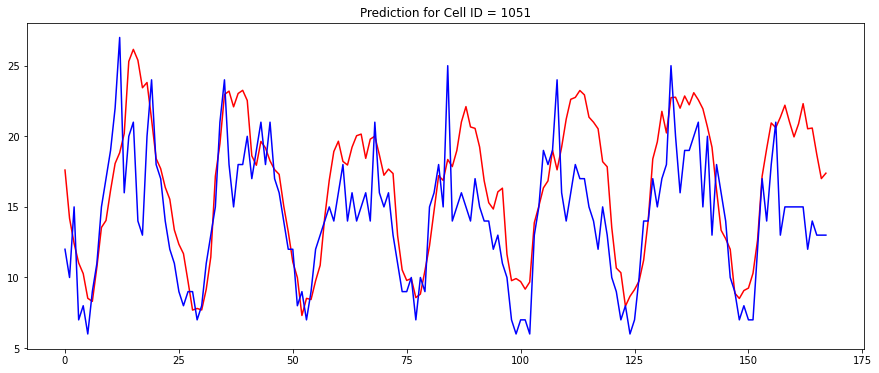

In [12]:
#--Ploting the actual result (not considering mean and std)
predictions_standardized = np.array(predictions_standardized)
predictions_week = predictions_standardized*time_series_std+time_series_mean

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d' % (Cell_ID[60])) 
plt.plot(predictions_week,'r')
plt.plot(y_test,'b')

In [13]:
MAE = mean_absolute_error(predictions_week,y_test)
MSE = mean_squared_error(predictions_week,y_test)
print('MAE:', "%.3f" % MAE)
print('MSE:', "%.3f" % MSE)

MAE: 3.180
MSE: 15.293
